# HASP Data Diagnostic Notebook

<hr>


## This notebook will walk you through how to examine the input spectra for the HASP `coadd` code and determine what was and was not included in the co-added data product output.

## Learning Goals

By the end of this tutorial, you will:
- Understand the reasons an input spectrum may be rejected from a co-added data product 
- Learn how to examine output logs from `coadd` and header keywords from COS and STIS data products to determine which datasets were rejected
- Know how to plot co-added spectra and the constituent datasets
- Be able to re-run `coadd` with the default rejection criteria turned off to create custom co-additions

## Table of Contents
**0. [Introduction](#introduction)**

**1. [Example 1: Two COS datasets rejected for different reasons](#cosweirddata)**

\- 1.1 [Obtaining Data Products](#data1)

\- 1.2 [Examining Output Logs](#logs1)

\- 1.3 [Plotting Constituent Spectra](#plots1)

\- 1.4 [Running `coadd`](#coadd1)

**2. [Example 2: A STIS dataset with `POSTARG` offsets](#stisdithers)**

\- 2.1 [Obtaining Data Products](#data2)

\- 2.2 [Examining Output Logs](#logs2)

\- 2.3 [Running `coadd`](#coadd2)

**3. [Example 3: A STIS dataset with rejected flux](#stisflux)**

\- 3.1 [Obtaining Data Products](#data3)

\- 3.2 [Examining Output Logs](#logs3)

\- 3.3 [Running `coadd`](#coadd3)

<a id = introduction></a>
## 0. Introduction

The [Hubble Advanced Spectral Products (HASP) `coadd` code](https://github.com/spacetelescope/hasp) is a script that co-adds spectra of the same target within a program. This software is able to co-add data taken with the spectrographs onboard the [Hubble Space Telescope (HST)](https://www.stsci.edu/hst); the [Space Telescope Imaging Spectrograph (STIS)](https://www.stsci.edu/hst/instrumentation/stis) and the [Cosmic Origins Spectrograph (COS)](https://www.stsci.edu/hst/instrumentation/cos). The [Hubble Spectroscopic Legacy Archive (HSLA)](https://archive.stsci.edu/missions-and-data/hst/hasp) uses this script to co-add these instruments’ data from [The Mikulski Archive for Space Telescopes (MAST)](https://archive.stsci.edu/) to create high-quality spectra with a broad wavelength coverage (whenever possible from the ultraviolet to the near-infrared) that is publicly available for the scientific community. The script first co-adds the observations for each grating for a given visit, then it combines all gratings for the observation set. Finally, it co-adds the spectra of each observation set in the program to produce a fully co-added spectra for each target in a program. [Check out the COS 2024-1 ISR for more information about the HASP script and products](https://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/cos/documentation/instrument-science-reports-isrs/_documents/ISR2024-01.pdf).

The data fed into the `coadd` code from each program are selected via a MAST archive search query. This query performs some filtering at the same time and rejects certain bad quality datasets. Then, the `coadd` script itself performs another series of checks on the input spectra before computing the co-added data products. Lastly, while `coadd` is running, it will check the flux of the input data in each wavelength bin for a given mode against an initial coadd that includes all input data. If the median flux of an input spectrum is lower than a given threshold against the co-add, it will be removed. `coadd` will iterate until no more spectra are rejected.

There are several different reasons an exposure could be rejected before the co-addition is running. These fall into three categories. First, the data in a given program may have quality issues that lead to its removal. Second, there are some observation configurations that `coadd` is not equipped to handle. Last, the target itself may pose an issue, such as for moving targets, or the target flux may be intrinsically variable, making the `coadd` flux filter reject good spectra. Finer details of these rejection criteria are summarized below:

| Reason                                                                                                             | Modes Effected |
|--------------------------------------------------------------------------------------------------------------------|----------------|
|**Observing Issues**                                                |                |
| Guide star acquisition failures                                                                                    | Any            |
| Observatory or detector failure events                                                                             | Any            |
| EXPFLAG (exposure data quality flag) header keyword is anything other than 'NORMAL'                                | Any            |
| EXPTIME (exposure time) is zero seconds                                                                            | Any            |
| Actual exposure time is less than 80% of the planned exposure time                                                 | Any            |
| FGSLOCK (fine guidance system lock) is not 'FINE', i.e., guide star tracking was not locked                        | Any            |
| SHUTTER is closed                                                                                                  | COS            |
| **Observation Parameters**                                             |                |
| POSTARG1 != 0.0, i.e., there is a pointing offset                                                                  | Any            |
| POSTARG2 != 0.0 and P1_PURPS != 'DITHER', i.e., there is a pointing offset not in the disperson direction          | STIS           |
| PATTERN1 = STIS-PERP-TO-SLIT and P1_FRAME = POS-TARG, i.e., there is a cross-dispersion direction pointing pattern | STIS           |
| P1_PURPS = MOSAIC, i.e., there is a mosaic pointing offset pattern                                                 | STIS           |
| OPT_ELEM (grating) = PRISM                                                                                         | STIS           |
| APERTURE = BOA (Bright Object Aperture)                                                                            | COS            |
| For the COS/NUV grating G230L, stripe C spectra are rejected due to vignetting                                     | COS/NUV        |
| **Target Parameters**                                               |                |
| Moving targets (MTFLAG = True)                                                                                     | Any            |
| Variable targets*                                                                                              | Any            |
| Extended targets*                                                                                               | Any            |

*These are not rejected by default, but some exposures may be removed by the code's flux checking routine.

The HSLA team chose to reject these cases after careful analysis, but understand there are always some exceptions to these rules that we do not handle. This custom co-addition notebook will show users how to find out why a dataset was rejected and how to produce their own co-adds in cases where the data are still valuable.

_Please note that the format and text in the log file may change slightly as new code builds are released. This notebook was last updated in Fall 2024 to reflect such text changes in the logs._

### Imports
We will be using multiple libraries to retrieve and analyze data. We will use:
* `astroquery.mast Observations` to download COS and STIS data
* `pathlib.Path` to create product and data directories
* `matplotlib.pyplot` to plot spectra
* `numpy` to perform calculations and array manipulation
* `astropy.io fits` to work with FITS files
* `astropy.table Table` to work with FITS tables
* `glob` to work with multiple files in our directories
* `os` to interact with the operating system
* `shutil` to perform directory and file operations
  
We recommend creating a HASP-specific `conda` environment when co-adding spectra. You can checkout our [Setup.ipynb](https://github.com/spacetelescope/hst_notebooks/tree/main/notebooks/HASP/Setup) notebook to create such an environment. Alternatively, you can also download the required dependencies to run this notebook with the terminal command:
```
pip install -r requirements.txt
```
This will download the dependencies that are necessary to run this current notebook. Let's import all of our packages that we will use in this notebook and print our `conda` environment by running the next cell:

In [1]:
from astropy.io import fits
from astropy.table import vstack
from astroquery.mast import Observations

import os
import glob
import shutil
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib widget

plt.rcParams['figure.figsize'] = 10, 6
plt.style.use('seaborn-v0_8-colorblind')

print("Currently active conda environment:", os.environ.get("CONDA_PREFIX"))

Currently active conda environment: /home/runner/micromamba/envs/hstcal


Please make sure the environment that contains the HASP script dependencies is activated or you download the dependencies listed in the `requirements.txt` file, otherwise **you will NOT be able to run the co-add code.**

We will define a function that will be utilized throughout the notebook when downloading MAST data using `astroquery`:

In [2]:
def consolidate_files(data_path):
    '''
    Consolidate all files to single directory; necessary for HASP script run.
    ---------------
    Input:
    str data_path : ./mastDownload/HST folders paths; files to be moved here
    ---------------
    Output:
    None. Files moved to data_path and data_path/products.
    The ./mastDownload/HST directory is deleted.
    '''
    # The path to all obs_id folders
    mast_path = f"{data_path}/mastDownload/HST/"
    try:
        # Check if mastDownload exists
        if not os.path.exists(mast_path):
            print(f"Directory {mast_path} doesn't exist.")
            return
        # Get a list of the obs_id paths in mastDownload
        obs_id_dirs = os.listdir(mast_path)
        # Iterate through each obs_id folder and move the files
        for obs_id in obs_id_dirs:
            obs_id_path = os.path.join(mast_path, obs_id)
            files = glob.glob(obs_id_path + "/*fits")
            for file in files:
                file_path = Path(file)
                new_path = data_path / file_path.name
                shutil.move(file, new_path)
        # Now we can remove the mastDownload directory
        if os.path.exists(mast_path):
            shutil.rmtree(f"{data_path}/mastDownload")
        # Now moving all coadd products to /data_path/products
        product_path = Path(f"{data_path}/products/")
        if not os.path.exists(product_path):
            print(f"Directory {product_path} doesn't exist.")
            return
        coadd_files = glob.glob(f"{data_path}/*cspec.fits")
        for file in coadd_files:
            file_path = Path(file)
            new_path = product_path / file_path.name
            shutil.move(file, new_path)
    except Exception as e:
        print(f"An error occurred: {e}")

<hr>


<a id = cosweirddata></a>
# Example 1: Two COS datasets rejected for different reasons

<a id = data1></a>
### 1.1 Obtaining Data Products

For this example, we will be looking at Program ID 12715, which observed four flux standard white dwarf stars with COS.
We will use `astroquery` to download the calibrated and coadded datasets for this program. For a more in-depth tutorial on downloading this data, please check out the [CoaddTutorial.ipynb](https://github.com/spacetelescope/hst_notebooks/tree/main/notebooks/HASP/CoaddTutorial) notebook in this repository.

We will create a folder for the `X1D` and `X1DSUM` products, called `./12715`, and a subfolder called `products`, which will store the coadded data. The log file for this coadd is also available for download on MAST, but a static version has been provided in this repository for convenience. This log file is located in `./logfiles` and is called `HASP_12715.out`. Log files are text files that can be opened and viewed in any text editor.

In [3]:
# Creating directories for our data and coadded products
datadir_ex1 = Path("./12715/")
productsdir_ex1 = Path("./12715/products/")

datadir_ex1.mkdir(exist_ok=True)
productsdir_ex1.mkdir(exist_ok=True)

Let's download our datasets for this program by running the cell below:

In [4]:
%%capture output

# Querying and downloading calibrated products
query_ex1 = Observations.query_criteria(
    proposal_id=12715, 
    provenance_name="CALCOS"
)

prodlist_ex1 = Observations.get_product_list(
    query_ex1
)

prodlist_ex1 = Observations.filter_products(
    prodlist_ex1,
    project=["CALCOS"],
    productSubGroupDescription=["X1D", "X1DSUM"]
)

# Querying and downloading coadded products
query_ex1_coadds = Observations.query_criteria(
    proposal_id=12715, 
    provenance_name="HASP"
)

prodlist_ex1_coadds = Observations.get_product_list(
    query_ex1_coadds
)

prodlist_ex1_coadds = Observations.filter_products(
    prodlist_ex1_coadds, 
    productType="SCIENCE",
    productSubGroupDescription="CSPEC"
)

# Combining the two product lists
combined_ex1 = vstack([prodlist_ex1, prodlist_ex1_coadds])

# Downloading the products
Observations.download_products(
    combined_ex1,
    download_dir=str(datadir_ex1)
)

# Organizing the files 
consolidate_files(datadir_ex1)

In [5]:
with open('output.txt', 'a') as file:
    file.write(output.stdout)

Now we will use `glob` to make a list of every `X1D` file available in MAST for this PID. We will print out a table of some table information on the program:

In [6]:
allfiles = glob.glob(os.path.join(datadir_ex1, '*_x1d.fits'))
print('rootname  target  visit  grating')

for x1d in sorted(allfiles):
    hdr0 = fits.getheader(x1d, ext=0)
    print(hdr0['rootname'], hdr0['targname'],
          hdr0['obset_id'], hdr0['opt_elem'])

print("-----------------------------------")
print(f"N files from MAST = {len(allfiles)}")

rootname  target  visit  grating
lbui01e7s WD0947+857 01 G140L
lbui01ebs WD0947+857 01 G140L
lbui01eds WD0947+857 01 G130M
lbui01efs WD0947+857 01 G130M
lbui01ehs WD0947+857 01 G130M
lbui02f1q WD0947+857 02 G140L
lbui02f3q WD0947+857 02 G140L
lbui02f5q WD0947+857 02 G130M
lbui02f7q WD0947+857 02 G130M
lbui02f9q WD0947+857 02 G130M
lbui03m6q WD0947+857 03 G140L
lbui03maq WD0947+857 03 G140L
lbui03mkq WD0947+857 03 G130M
lbui03mmq WD0947+857 03 G130M
lbui03mpq WD0947+857 03 G130M
lbui04m6q WD0947+857 04 G140L
lbui04meq WD0947+857 04 G140L
lbui04mhq WD0947+857 04 G130M
lbui04mlq WD0947+857 04 G130M
lbui04mnq WD0947+857 04 G130M
lbui05aaq WD0947+857 05 G140L
lbui05acq WD0947+857 05 G140L
lbui05ajq WD0947+857 05 G130M
lbui05amq WD0947+857 05 G130M
lbui05aoq WD0947+857 05 G130M
lbui06guq WD0947+857 06 G140L
lbui06gyq WD0947+857 06 G140L
lbui06h0q WD0947+857 06 G130M
lbui06h2q WD0947+857 06 G130M
lbui06h4q WD0947+857 06 G130M
lbui07dkq WD0947+857 07 G140L
lbui07dpq WD0947+857 07 G140L
lbui07d

<a id = logs1></a>
### 1.2 Examining Output Logs and Headers

Now lets open the `coadd` output log to see which files were used in the coadd.

In [7]:
# Set up path to the coadd log file
logfile = './logfiles/HASP_12715.out'

with open(logfile, 'r') as f:
    for line in f:
        print(line.strip())

2024256063356 INFO src=hasp_retrieve_inputs.filter_out_low_quality_datasets msg="Removed COS singleton lbui11faq"
2024256063357 INFO src=hasp_retrieve_inputs.filter_out_low_quality_inputs fsn=bui msg="Removed 1 entry due to low quality"
2024256063357 INFO src=hasp_retrieve_inputs-hap_verify_poller_file.remove_entries_to_skip msg="Checking whether any ipppssoots are in the SkipAlignment table"
2024256063357 INFO src=hasp_retrieve_inputs-hap_verify_poller_file.remove_entries_to_skip msg="No exposures for this visit are in the SkipAlignment table. This visit will be processed fully."

2024256063426 INFO src=hasp_coadds.get_resource_path_values msg="Using haspsp.resource and repro_sci.path"
2024256063426 INFO src=hasp_coadds-run_swrapper.run_swrapper_script fsn=bui msg="Running swrapper -i ...bui -o ...bui in the calibration software conda environment: caldp_20240813"
HASP version 1.0
Ullyses version 4.1.0
File ...lbui51l6q_x1d.fits removed from products because FGSLOCK = FINE/GYRO
File ..

As stated in the introduction, files can be removed from the co-added products in three steps. First, some files are excluded via a MAST archive query before they are even fed into `coadd`. Everything in the log file above the line that states `HASP version X.X` is output from this query. So, in this example, we can see that all but one of the files from MAST were fed into the `coadd` script. The rootname of the file (`lbui11faq`) and the reason for its removal by MAST are shown and we will take a closer look at the reason later. The rest of the log file gives the output from `coadd` itself. The `coadd` script output will indicate when a file is removed, giving both the filename and the reason, below the line that states `Ullyses version X.X.X`. Typically, data with observing issues are removed by the MAST query, while observation or target parameter issues are removed in `coadd`. Looking through the log file, we can see 9 other files were removed by `coadd` in this program:

```
File ...lbui51l6q_x1d.fits removed from products because FGSLOCK = FINE/GYRO 
File ...lbui51lcq_x1d.fits removed from products because FGSLOCK = FINE/GYRO 
File ...lbui51lrq_x1d.fits removed from products because FGSLOCK = FINE/GYRO 
File ...lbui51ltq_x1d.fits removed from products because FGSLOCK = FINE/GYRO 
File ...lbui51lvq_x1d.fits removed from products because FGSLOCK = FINE/GYRO 
File ...lbui51m5q_x1d.fits removed from products because FGSLOCK = FINE/GYRO 
File ...lbui51m7q_x1d.fits removed from products because FGSLOCK = FINE/GYRO 
File ...lbui51mbq_x1d.fits removed from products because FGSLOCK = FINE/GYRO 
File ...lbui51mdq_x1d.fits removed from products because FGSLOCK = FINE/GYR0 
```

This program does not have any data that is removed by the `coadd` flux checker. If a dataset is removed, it will be printed with lines such as:

```
Using a maximum SNR of 20 in flux-based filtering \
Segment #1 from file ...lede16w8q_x1d.fits has scaled median = -54.04932196288165 \
Removing file ...lede16w8q_x1d.fits from product
```

Next, we will write a function to parse the output logs and return lists of the files that were rejected.

In [8]:
def find_rejects(logpath, pid, listofallfiles):
    """
    This function parses the coadd output log file to make a list of files that
    were input to the coadd script. The function uses the PID to find the lines
    that are listed like so in the log file:
        Creating list of unique modes from these files:
        ...lbui01e7s_x1d.fits WD0947+857 COS FUV G140L PSA 12715 (12715, '01')
        ...
        ...lbui50r5q_x1d.fits WD0308-565 COS FUV G140L PSA 12715 (12715, '50')
    Then, it compares that to the list of every file from the program that you
    download from MAST. The difference in the two lists are the rejected files.

    It looks through the log for files that were rejected by the flux checker.
    This searches for lines that are printed like so in the log file:
        Removing file ...lede16w8q_x1d.fits from product
    Because a file can be removed more than once in the creation of different
    level data products, the list returned will only include unique entries.

    Args:
        logname (string): Path to the coadd output log file
        pid (string): Proposal ID of the program
        listofallfiles (list of strings): list of every path+filename program

    Returns:
        prerejectedfiles (list of str): list of files rejected by MAST query
                                        or coadd before computations began
        fluxrejectedfiles (list of str): list of files rejected by flux checker
    """

    # Open output log and make a list of rootnames that were used in the coadd
    # Also search for rootnames that were rejected by the flux checker
    with open(logpath, 'r') as f:
        lines = f.readlines()
    coaddedfiles = []
    fluxrejectedfiles = []
    for line in lines:
        if ('...' in line.strip()) and ('('+pid+',' in line.strip()):
            coaddedfiles.append(line.split()[0].split('...')[1])
        if 'Removing file' in line.strip():
            fluxrejectedfiles.append(line.split()[2].split('...')[1])

    # Compare coadd list against list of all files in PID downloaded from MAST
    prerejectedfiles = []
    for filepath in listofallfiles:
        root = filepath.split('/')[-1]
        if root not in coaddedfiles:
            prerejectedfiles.append(root)

    return prerejectedfiles, np.unique(fluxrejectedfiles)

In [9]:
# Run find_rejects and print the output
listofprerejects, listoffluxrejects = find_rejects(logfile, '12715', allfiles)
print('Files removed before co-addition:')
[print(f"{file}") for file in sorted(listofprerejects)]
print(f'Files removed by flux checker: {sorted(listoffluxrejects)}')
print(f'Number of files removed before co-addition = {len(listofprerejects)}')
print(f'Number of files removed by flux checker = {len(listoffluxrejects)}')

Files removed before co-addition:
lbui11faq_x1d.fits
lbui51l6q_x1d.fits
lbui51lcq_x1d.fits
lbui51lrq_x1d.fits
lbui51ltq_x1d.fits
lbui51lvq_x1d.fits
lbui51m5q_x1d.fits
lbui51m7q_x1d.fits
lbui51mbq_x1d.fits
lbui51mdq_x1d.fits
Files removed by flux checker: []
Number of files removed before co-addition = 10
Number of files removed by flux checker = 0


We can see 10 files were removed before the co-addition computations were started, and none were removed during the run by the flux checker. We already knew the files in Visit 51 were removed by `coadd` (and why) by looking at the output log above. The file from Visit 11 (`lbui11faq_x1d.fits`) was removed by the MAST query due to "low quality." We can investigate the rejections from both visits further by inspecting the header keywords of the input spectra.

In the following cell, we make a function to read the file headers for each input spectrum. Most of the reasons for rejection that are listed in the [Introduction](#introduction) section can be found either in the primary or first extension headers. This function can be used to inspect both COS and STIS extracted data, both `x1d` or `sx1` files. Note that some keywords, such as those describing the offset patterns, are only included in STIS files.

There are a few other keywords not listed in the [Introduction](#introduction) that are useful to assess as well. These include the quality comments (`QUALCOM1`, `QUALCOM2`, `QUALCOM3`), the file date (`DATE`), and calibration software version (`CAL_VER`). 

The quality comments can hold information about the quality of a dataset. For example, they may have phrases like `Guide star acquisition failed. Actual guide mode is gyro` or `COS internal shutter closed. No counts in exposure`. If there is nothing to note for the dataset, the quality comments will be blank, but note that sometimes this can be inaccurate, as it relies on PIs to file problem reports. For STIS, these keys are in the `x1d` or `sx1` file headers. For COS, they are located in the `x1dsum` files that CalCOS creates, which are the sum of `FP-POS` exposures for a given observing mode in each visit. While these keywords do exist in COS `x1d` files, they will only be populated with comments in the `x1dsums`. To find the `x1dsum` file for these observations, we can use the `ASN_ID` keyword from the `x1ds`.

The date the file was written and the version of the software used for calibration are useful for finding datasets that are archived "statically" in MAST, meaning they are always excluded from re-calibration because doing so will crash the latest versions of the calibration pipeline. There are only a handful of statically archived datasets for COS and STIS. The reasons they need to be designated as such are usually due to detector or spacecraft issues that need very specialized processing, and this is not always captured in the quality comments. Therefore, we do not recommend using these datasets in co-adds.

In [10]:
def readheaders(prerejectedfiles, datadir):
    """
    This function goes through a list of the pre-rejected files and prints the 
    x1d header information about data quality. Some of these quality comments 
    can describe issues that might have occured during the observation. 
    Args:
        prerejectedfiles (list of strings): list of rejected filenames
        datadir (str): path to x1d/sx1/x1dsum files
    """

    for badfile in sorted(prerejectedfiles):
        badfilepath = os.path.join(datadir, badfile)
        print(badfilepath)
        # Open the 0th and 1st ext. headers to get data quality info
        hdr0 = fits.getheader(badfilepath, ext=0)
        hdr1 = fits.getheader(badfilepath, ext=1)

        # Note that header keywords differ between COS and STIS
        ins = hdr0['INSTRUME']

        # print lots of keywords
        print(f"Exposure time = {hdr1['EXPTIME']}")
        # These keywords doesn't exist in STIS data
        if ins == 'COS':
            print(f"Planned exposure time = {hdr1['PLANTIME']}")
            print(f"Shutter = {hdr0['SHUTTER']}")
        print(f"Aperture used = {hdr0['APERTURE']}")
        print(f"Grating used = {hdr0['OPT_ELEM']}")
        print(f"Exposure flag = {hdr1['EXPFLAG']}")
        print(f"Fine guiding lock = {hdr1['FGSLOCK']}")
        print(f"POSTARG1 / POSTARG2 = {hdr0['POSTARG1']} / {hdr0['POSTARG2']}")
        # These keywords are not present in COS x1d data
        if ins == 'STIS':
            print(f"Offset pattern = {hdr0['PATTERN1']}")
            print(f"P1 frame = {hdr0['P1_FRAME']}")
            print(f"P1 purpose = {hdr0['P1_PURPS']}")
            print('Quality comments')
            print(f"    COM1 = {hdr0['QUALCOM1']}")
            print(f"    COM2 = {hdr0['QUALCOM2']}")
            print(f"    COM3 = {hdr0['QUALCOM3']}")
        # Find the x1dsum for the COS data to get the quality comments
        if ins == 'COS':
            asn_id = hdr0['ASN_ID']
            x1dsum = os.path.join(datadir, asn_id.lower() + '_x1dsum.fits')
            if os.path.isfile(x1dsum):
                print(f'Quality comments from {x1dsum}')
                print('    COM1 = ' + fits.getval(x1dsum, 'QUALCOM1', ext=0))
                print('    COM2 = ' + fits.getval(x1dsum, 'QUALCOM2', ext=0))
                print('    COM3 = ' + fits.getval(x1dsum, 'QUALCOM3', ext=0))
            else:
                print('Quality comments: No x1dsum available')
        if hdr0['MTFLAG'] != 'T':
            print('Moving target? No')
        else:
            print('Moving target? Yes')
        print(f"Date file was written = {hdr0['DATE']}")
        print(f"Version of calibration software = {hdr0['OPUS_VER']}")
        print('')
        print('')

In [11]:
readheaders(listofprerejects, datadir_ex1)

12715/lbui11faq_x1d.fits
Exposure time = 415.6800231933594
Planned exposure time = 416.0
Shutter = Open
Aperture used = PSA
Grating used = G130M
Exposure flag = NORMAL
Fine guiding lock = FINE
POSTARG1 / POSTARG2 = 0.0 / 0.0
Quality comments: No x1dsum available
Moving target? No
Date file was written = 2012-05-02
Version of calibration software = OPUS 2012_1


12715/lbui51l6q_x1d.fits
Exposure time = 226.016
Planned exposure time = 226.0
Shutter = Open
Aperture used = PSA
Grating used = G130M
Exposure flag = NORMAL
Fine guiding lock = FINE/GYRO
POSTARG1 / POSTARG2 = 0.0 / 0.0
Quality comments from 12715/lbui51010_x1dsum.fits
    COM1 = 
    COM2 = 
    COM3 = 
Moving target? No
Date file was written = 2025-07-18
Version of calibration software = HSTDP 2025_1


12715/lbui51lcq_x1d.fits
Exposure time = 244.0
Planned exposure time = 244.0
Shutter = Open
Aperture used = PSA
Grating used = G130M
Exposure flag = NORMAL
Fine guiding lock = FINE/GYRO
POSTARG1 / POSTARG2 = 0.0 / 0.0
Quality co

Inspecting the output from the header keywords printed above, we see there is no `x1dsum` to inspect for `lbui11faq_x1d.fits`. This is unusual for COS data! We can also see that the date the file was written was in 2012, and that the version of the calibration software used to calibrate this data was from 2012. All together, this indicates that this dataset is statically archived in MAST, and so we don't recommend using it in a co-add. To see the latest versions of the calibration pipeline software, see the [HST Data Processing (HSTDP) github page](https://github.com/astroconda/astroconda-releases/tree/master/caldp).

We can also see that the quality comments are all blank for the Visit 51 datasets. We know from the output log file that these data were rejected because some of the exposure was observed using gyro guiding, which is less accurate than fine guiding that tracks targets with guide stars. Because there are no quality comments listed to indicate a target acquisition failure, this data may still be useable, and we'll explore that next. This data is of target `WD0308-565`, which was also observed in Visit 50 with the same observing setup. We can compare the fluxes of the two visits to see if Visit 51's data is alright for co-addition.

<a id = plots1></a>
### 1.3 Plotting Constituent and Co-added Spectra 

In [12]:
# Define a function to bin the data so it will plot more clearly
def downsample_1d(myarr, factor):
    """
    Downsample a 1D array by averaging over *factor* pixels.
    Crops right side if the shape is not a multiple of factor.
    Got this specific function from "Adam Ginsburg's python codes" on agpy

    myarr : numpy array
    factor : how much you want to rebin the array by
    """
    xs = myarr.shape[0]
    crarr = myarr[:xs-(xs % factor)]
    dsarr = crarr.reshape(-1, factor).mean(axis=1)
    return dsarr

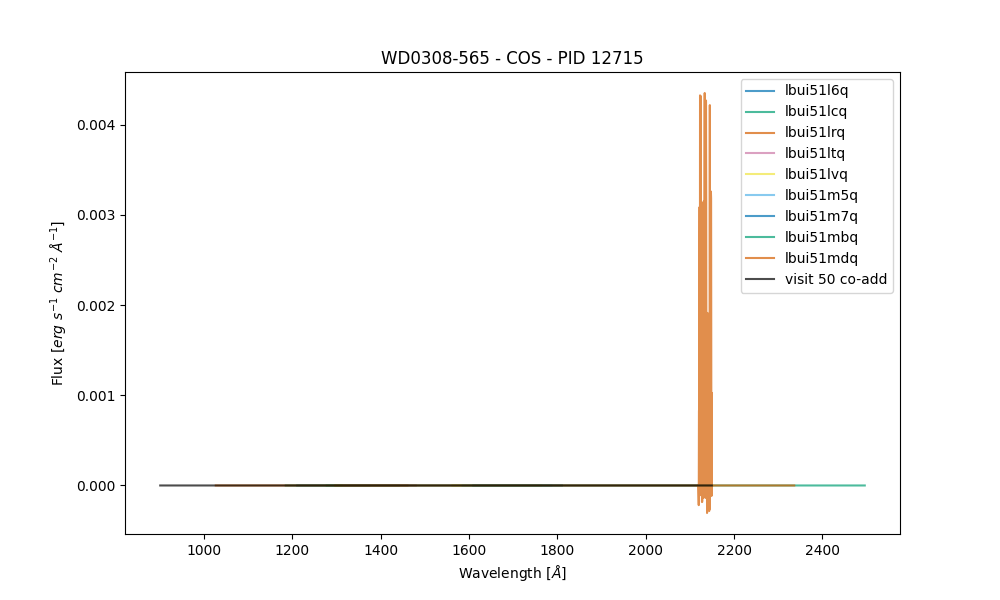

In [13]:
filename = 'hst_12715_cos_wd0308-565_cg140l-g130m-g160m_lbui50_cspec.fits'

# Set up a path to the visit 50 level co-added data product for this target
coaddfile = os.path.join(datadir_ex1, 'products', filename)
coadddata = fits.getdata(coaddfile)

# Proactively set sample factor to 6, which is size of COS resolution element
# For STIS, this is 2
samplefactor = 6

# The visit we want to plot
visit_to_plot = "51"

# Get the wavelength and flux data for the co-added file
wavelength = coadddata['wavelength'][0]
flux = coadddata['flux'][0]

# Set up the plot
plt.close()
plt.figure(1)

# Plot the constiuent spectra
for x1d in sorted(allfiles):
    # First check that the file is for the correct visit
    visit_id = fits.getval(x1d, 'obset_id', ext=0)
    if visit_id == visit_to_plot:
        x1ddata = fits.getdata(x1d)
        subwave = x1ddata['wavelength'][0]
        subflux = x1ddata['flux'][0]
        plt.plot(downsample_1d(subwave, samplefactor),
                 downsample_1d(subflux, samplefactor),
                 label=fits.getval(x1d, 'rootname', ext=0),
                 alpha=0.7)

# Overplot the co-add
plt.plot(downsample_1d(wavelength, samplefactor),
         downsample_1d(flux, samplefactor),
         c='black',
         label='visit 50 co-add',
         alpha=0.7)

# Format the plot by adding titles
targ = fits.getval(coaddfile, 'TARGNAME', ext=0)
pid = fits.getval(coaddfile, 'PROPOSID', ext=0)
ins = fits.getval(coaddfile, 'INSTRUME', ext=0)

plt.title(f'{targ} - {ins} - PID {pid}')
plt.xlabel(r'Wavelength [$\AA$]')
plt.ylabel(r'Flux [$erg\ s^{-1}\ cm^{-2}\ \AA^{-1}$]')
plt.legend()

# Show the plot below
plt.show()

Use the interactive features in the top left corner to zoom in on a region of continuum in the plot above. The zoom button looks like a square and allows you to select a rectangular region on the plot to enlarge. We see no systematic difference in the data from Visit 51 compared to the co-added data in Visit 50, so let's add the Visit 51 data into the co-add.

<a id = coadd1></a>
### 1.4 Re-running `coadd`

Now that we know which data we want to use in the custom co-add, we must create a new directory with all the data from Visits 50 and 51. We will feed `coadd` the data from this new directory from its `wrapper` script. Running `coadd` this way essentially skips the filtering that the MAST query applies, but `coadd` itself still has some internal data quality checks, as mentioned above, so we will need to turn those off. If there is data you still want `coadd` exclude that was filtered before, be sure to not put those in the data directory!

The following cell is the call to `coadd` via its `wrapper`. The `-i` parameter is the input directory you just made. `-o` is the directory that will contain the newly created co-added products. The `-k` turns off the data quality filtering. There is more information about this in our [Setup.ipynb](https://github.com/spacetelescope/hst_notebooks/tree/main/notebooks/HASP/Setup) notebook.

In [14]:
# Set up the path to your new data directory
finaldatadir = os.path.join(datadir_ex1, 'newcoadddata')
os.makedirs(finaldatadir, exist_ok=True)

# Copy all the data from visits 50 and 51 into it
filestocopy = glob.glob(os.path.join(datadir_ex1, '*50*_x1d.fits'))\
            + glob.glob(os.path.join(datadir_ex1, '*51*_x1d.fits'))

[shutil.copy(file, finaldatadir) for file in filestocopy]

# Make an output directory
os.makedirs(os.path.join(datadir_ex1, 'newcoadddata', 'products'), exist_ok=True)

To call `coadd`, we use the `!` to run from the command line. The directories here must be printed out in full - don't use variable names:

In [15]:
%%capture output

!swrapper -i ./12715/newcoadddata -o ./12715/newcoadddata/products -k

In [16]:
with open('output.txt', 'a') as file:
    file.write(output.stdout)

#### Replot the co-added data

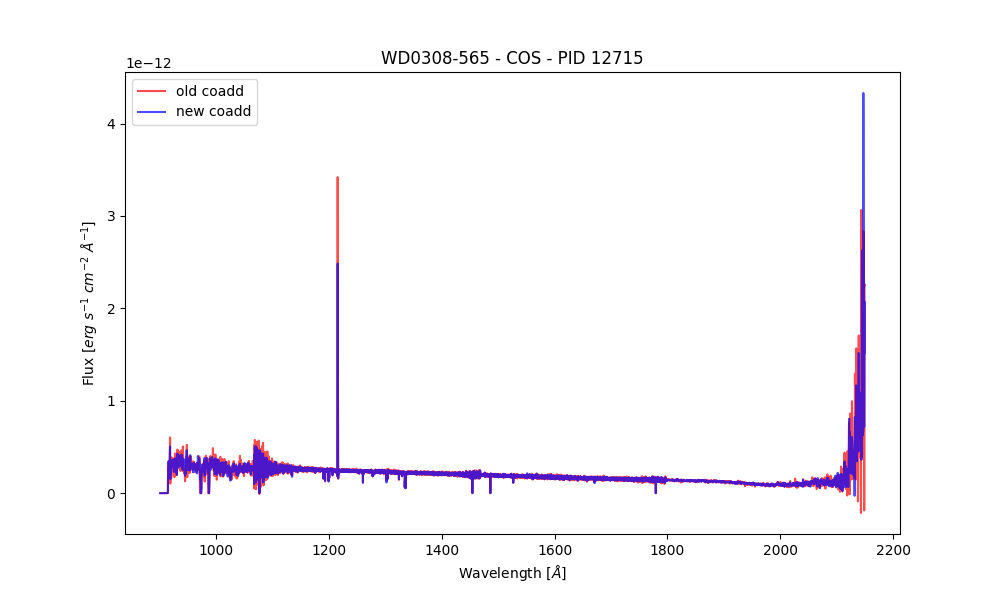

In [17]:
# Clear the older plot
plt.close()
plt.figure(2)

coadd_filename = 'hst_12715_cos_wd0308-565_cg140l-g130m-g160m_lbui_cspec.fits'

# Plot the old coadd
oldcoaddfile = os.path.join(datadir_ex1, 'products', coadd_filename)
oldcoadddata = fits.getdata(oldcoaddfile)
oldwavelength = oldcoadddata['wavelength'][0]
oldflux = oldcoadddata['flux'][0]

plt.plot(downsample_1d(oldwavelength, samplefactor),
         downsample_1d(oldflux, samplefactor),
         label='old coadd',
         color="red",
         alpha=0.7)

# Plot the new coadd
newcoaddfile = os.path.join(finaldatadir, 'products', coadd_filename)
newcoadddata = fits.getdata(newcoaddfile)
newwavelength = newcoadddata['wavelength'][0]
newflux = newcoadddata['flux'][0]

plt.plot(downsample_1d(newwavelength, samplefactor),
         downsample_1d(newflux, samplefactor),
         label='new coadd',
         color="blue",
         alpha=0.7)

targ = fits.getval(coaddfile, 'TARGNAME', ext=0)
pid = fits.getval(coaddfile, 'PROPOSID', ext=0)
ins = fits.getval(coaddfile, 'INSTRUME', ext=0)

plt.title(f'{targ} - {ins} - PID {pid}')
plt.xlabel(r'Wavelength [$\AA$]')
plt.ylabel(r'Flux [$erg\ s^{-1}\ cm^{-2}\ \AA^{-1}$]')
plt.legend()

# Show the plot below
plt.show()

Let's also plot the signal-to-noise to see the improvement.

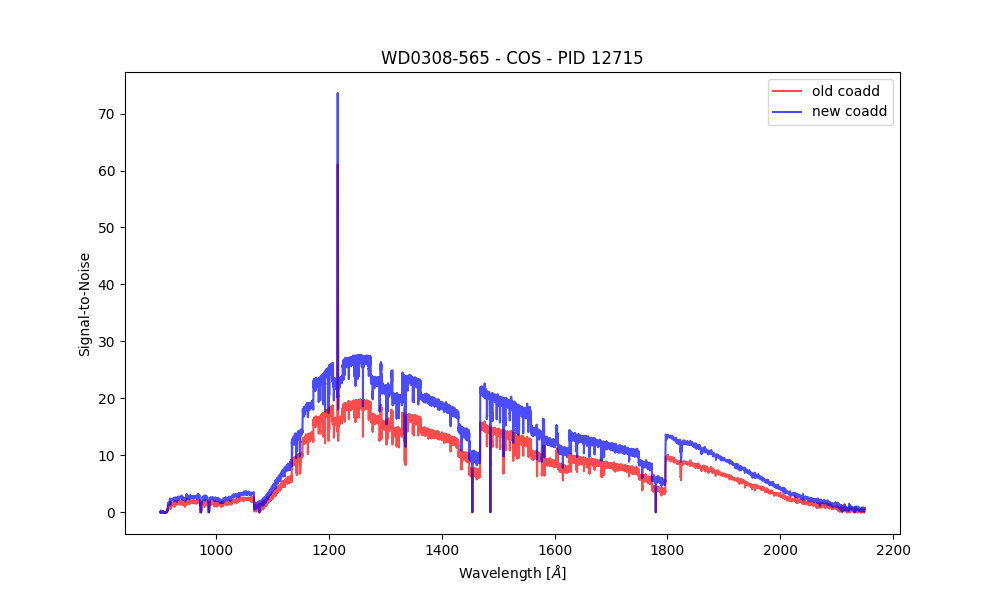

In [18]:
# Clear the older plot
plt.close()
plt.figure(3)

# Plot the old coadd SNR
oldsnr = oldcoadddata['snr'][0]
plt.plot(downsample_1d(oldwavelength, samplefactor),
         downsample_1d(oldsnr, samplefactor),
         label='old coadd',
         color="red",
         alpha=0.7)

# Plot the new coadd SNR
newsnr = newcoadddata['snr'][0]
plt.plot(downsample_1d(newwavelength, samplefactor),
         downsample_1d(newsnr, samplefactor),
         label='new coadd',
         color="blue",
         alpha=0.7)

plt.title(f'{targ} - {ins} - PID {pid}')
plt.xlabel(r'Wavelength [$\AA$]')
plt.ylabel(r'Signal-to-Noise')
plt.legend()

# Show the plot below
plt.show()

We can tell from the plot above that the SNR is much improved by adding the Visit 51 data into the co-add!

<a id = stisdithers></a>
# Example 2: A STIS dataset with POSTARG offsets

<a id = data2></a>
### 2.1 Obtaining Data Products

For the next example, we will look at Program ID 16655, a STIS program that observed the star [Betelgeuse](http://simbad.cds.unistra.fr/simbad/sim-basic?Ident=Betelgeuse&submit=SIMBAD+search) with the `E230M` grating centered on the target and at `POSTARGs` `+/-0.25 mas` and `+/- 0.5 mas`. Each visit in the programs contains the same spatial scan in the pattern `+0.5 mas`, `-0.5 mas`, `centered`, `+0.25 mas`, `-0.25 mas`. `coadd` will co-add the centered datasets in each visit, but will reject the other datasets with `POSTARGs`. 

We will again use `astroquery` to download the dataproducts for this program. We will create a folder for the `X1D` products, called `./16655`, and a subfolder called `products`, which will store the downloaded coadded data. The log file for this program is named `HASP_16655.out`.

In [19]:
# Creating directories for our data and coadded products
datadir_ex2 = Path("./16655/")
productsdir_ex2 = Path("./16655/products/")

datadir_ex2.mkdir(exist_ok=True)
productsdir_ex2.mkdir(exist_ok=True)

In [20]:
%%capture output

# Querying and downloading calibrated products
query_ex2 = Observations.query_criteria(
    proposal_id=16655, 
    provenance_name="CALSTIS",
    filters="E230M",
    target_name="HD39801"
)

prodlist_ex2 = Observations.get_product_list(
    query_ex2
)

prodlist_ex2 = Observations.filter_products(
    prodlist_ex2,
    project=["CALSTIS"],
    productSubGroupDescription=["X1D"]
)

# Querying and downloading coadded products
query_ex2_coadds = Observations.query_criteria(
    proposal_id=16655, 
    provenance_name="HASP",
    filters="E230M",
    target_name="HD39801"
)

prodlist_ex2_coadds = Observations.get_product_list(
    query_ex2_coadds
)

prodlist_ex2_coadds = Observations.filter_products(
    prodlist_ex2_coadds, 
    productType="SCIENCE",
    productSubGroupDescription="CSPEC"
)

# Combining the two product lists
combined_ex2 = vstack([prodlist_ex2, prodlist_ex2_coadds])

# Downloading the products
Observations.download_products(
    combined_ex2,
    download_dir=str(datadir_ex2)
)

# Organizing the files 
consolidate_files(datadir_ex2)

In [21]:
with open('output.txt', 'a') as file:
    file.write(output.stdout)

Now let's print some table information from our datasets:

In [22]:
allfiles = glob.glob(os.path.join(datadir_ex2, '*_x1d.fits'))
print('rootname  target  visit  grating')

for x1d in sorted(allfiles):
    hdr0 = fits.getheader(x1d, ext=0)
    print(hdr0['rootname'], hdr0['targname'],
          hdr0['obset_id'], hdr0['opt_elem'])

print("-----------------------------------")
print(f'N files from MAST = {len(allfiles)}')

rootname  target  visit  grating
oen701030 HD39801 01 E230M
oen701040 HD39801 01 E230M
oen702010 HD39801 02 E230M
oen702020 HD39801 02 E230M
oen702030 HD39801 02 E230M
oen702040 HD39801 02 E230M
oen702050 HD39801 02 E230M
oen703010 HD39801 03 E230M
oen703020 HD39801 03 E230M
oen703030 HD39801 03 E230M
oen703040 HD39801 03 E230M
oen703050 HD39801 03 E230M
oen704010 HD39801 04 E230M
oen704020 HD39801 04 E230M
oen704030 HD39801 04 E230M
oen704040 HD39801 04 E230M
oen704050 HD39801 04 E230M
oen705010 HD39801 05 E230M
oen705020 HD39801 05 E230M
oen705030 HD39801 05 E230M
oen705040 HD39801 05 E230M
oen705050 HD39801 05 E230M
oen751010 HD39801 51 E230M
oen751020 HD39801 51 E230M
oen751030 HD39801 51 E230M
oen751040 HD39801 51 E230M
oen751050 HD39801 51 E230M
-----------------------------------
N files from MAST = 27


<a id = logs2></a>
### 2.2 Examining Output Logs and Headers

Let's look at the log next.

In [23]:
# Set up path to the coadd log file
logfile = './logfiles/HASP_16655.out'

with open(logfile, 'r') as f:
    for line in f:
        print(line.strip())

2024192135321 INFO src=hasp_retrieve_inputs.filter_out_low_quality_datasets msg="Removed STIS HASP product oen701030"
2024192135321 INFO src=hasp_retrieve_inputs.filter_out_low_quality_datasets msg="Removed STIS HASP product oen701040"
2024192135321 INFO src=hasp_retrieve_inputs.filter_out_low_quality_inputs fsn=en7 msg="Removed 2 entries due to low quality"
2024192135322 INFO src=hasp_retrieve_inputs-hap_verify_poller_file.remove_entries_to_skip msg="Checking whether any ipppssoots are in the SkipAlignment table"
2024192135322 INFO src=hasp_retrieve_inputs-hap_verify_poller_file.remove_entries_to_skip msg="No exposures for this visit are in the SkipAlignment table. This visit will be processed fully."

2024192135345 INFO src=hasp_coadds.get_resource_path_values msg="Using haspsp.resource and repro_sci.path"
2024192135345 INFO src=hasp_coadds-run_swrapper.run_swrapper_script fsn=en7 msg="Running swrapper -i ...en7 -o ...en7 in the calibration software conda environment: caldp_20240509"

We can see that two files were removed by the MAST query and that many other files were removed from the co-add because of `POSTARG` offsets, as expected. There are also some files that were removed later by the flux checker. Let's see which files, and how many were rejected next.

In [24]:
# Use the find_rejects function to make list of pre-rejected files
listofprerejects, listoffluxrejects = find_rejects(logfile, '16655', allfiles)
print(f'Files removed before co-addition: {sorted(listofprerejects)}')
print(f'Files removed by flux checker: {sorted(listoffluxrejects)}')
print(f'Number of files removed before co-addition = {len(listofprerejects)}')
print(f'Number of files removed by flux checker = {len(listoffluxrejects)}')

Files removed before co-addition: ['oen701030_x1d.fits', 'oen701040_x1d.fits', 'oen702010_x1d.fits', 'oen702020_x1d.fits', 'oen702040_x1d.fits', 'oen702050_x1d.fits', 'oen703010_x1d.fits', 'oen703020_x1d.fits', 'oen703040_x1d.fits', 'oen703050_x1d.fits', 'oen704010_x1d.fits', 'oen704020_x1d.fits', 'oen704040_x1d.fits', 'oen704050_x1d.fits', 'oen705010_x1d.fits', 'oen705020_x1d.fits', 'oen705040_x1d.fits', 'oen705050_x1d.fits', 'oen751010_x1d.fits', 'oen751020_x1d.fits', 'oen751040_x1d.fits', 'oen751050_x1d.fits']
Files removed by flux checker: ['oen702030_x1d.fits', 'oen703030_x1d.fits', 'oen704030_x1d.fits', 'oen705030_x1d.fits']
Number of files removed before co-addition = 22
Number of files removed by flux checker = 4


Next, look in the `x1d` headers to find the exposure information and quality comments.

In [25]:
readheaders(listofprerejects, datadir_ex2)

16655/oen701030_x1d.fits
Exposure time = 2723.0
Aperture used = 0.1X0.03
Grating used = E230M
Exposure flag = NORMAL
Fine guiding lock = FINE
POSTARG1 / POSTARG2 = 0.0 / 0.0
Offset pattern = NONE
P1 frame = 
P1 purpose = 
Quality comments
    COM1 = Guide star acquisition failed. Actual guide mode is gyro.
    COM2 = STIS aperture door shut throughout exposure.  No counts in exposure.
    COM3 = Actual exposure time significantly less than planned exposure.
Moving target? No
Date file was written = 2025-07-26
Version of calibration software = HSTDP 2025_2


16655/oen701040_x1d.fits
Exposure time = 2723.0
Aperture used = 0.1X0.03
Grating used = E230M
Exposure flag = NORMAL
Fine guiding lock = FINE
POSTARG1 / POSTARG2 = 0.025 / 0.0
Offset pattern = NONE
P1 frame = 
P1 purpose = 
Quality comments
    COM1 = Guide star acquisition failed. Actual guide mode is gyro.
    COM2 = STIS aperture door shut throughout exposure.  No counts in exposure.
    COM3 = Actual exposure time significantly 

Looking through this output, we can see there are two datasets from Visit 01 (oen701030_x1d.fits and oen701040_x1d.fits) that had failed target acquisitions and were removed from the co-add. The quality comments tell us the aperture door was closed through the whole exposure, so no useful data was taken. The rest of the datasets were rejected because of the `POSTARG` offsets, as we already knew, and there are no other quality issues.

This leaves only five datasets that were included in the call to create the default versions of the data products: `oen702030_x1d.fits`, `oen703030_x1d.fits`, `oen704030_x1d.fits`, `oen705030_x1d.fits`, and `oen751030_x1d.fits`. However, the data in Visits 2, 3, 4, and 5 were later removed by the flux checker. Since this program was designed to probe Betelgeuse's recent flux variability, it makes sense that some of the fluxes may indeed be flagged for removal. In the custom co-add runs we perform next, we can set flags to ignore the `POSTARG` and flux filtering.

<a id = coadd1></a>
### 2.3 Running `coadd`

The structure of the program is such that each visit observed Betelgeuse at many `POSTARG` positions using the same gratings. The spatial scanning pattern is uniform, and so a user may wish to create co-adds of the spectra observed at each pointing position across all the visits. To co-add these, we can follow the same steps as in [Section 1.4](#coadd1), but set up five different directories for each pointing position. We'll create the directories:
| Directory                                                                                                             | Contains Datasets |
|--------------------------------------------------------------------------------------------------------------------|----------------|
| `newcoadddata_p50`                                                                                    | `oen702010_x1d.fits`, `oen703010_x1d.fits`, `oen704010_x1d.fits`, `oen705010_x1d.fits`, `oen751010_x1d.fits`            |
| `newcoadddata_p25`                                                                             | `oen702040_x1d.fits`, `oen703040_x1d.fits`, `oen704040_x1d.fits`, `oen705040_x1d.fits`, `oen751040_x1d.fits`            |
| `newcoadddata_p0.0`                                | `oen702030_x1d.fits`, `oen703030_x1d.fits`, `oen704030_x1d.fits`, `oen705030_x1d.fits`, `oen751030_x1d.fits`            |
| `newcoadddata_p-25`                                                                            | `oen702050_x1d.fits`, `oen703050_x1d.fits`, `oen704050_x1d.fits`, `oen705050_x1d.fits`, `oen751050_x1d.fits`            |
| `newcoadddata_p-50`                                                                            | `oen702020_x1d.fits`, `oen703020_x1d.fits`, `oen704020_x1d.fits`, `oen705020_x1d.fits`, `oen751020_x1d.fits`            |


Note that we'll still need to exclude the Visit 01 data that was rejected from the MAST query, as that step is bypassed when we run `coadd` from a local folder. Like in the first example, we add the flag `-k` to the call to turn off the `POSTARG` filtering. This time, we'll also add `-t -99999` to set the flux checking threshold. Setting this to a very large negative number will essentially override the flux filtering that `coadd` performs.

In [26]:
# Get a list of all files in the directory
allfiles = glob.glob(os.path.join(datadir_ex2, '*.fits'))

# Sort through all the files based on POSTARG value
postvals = ['-0.05', '-0.025', '0.0', '0.025', '0.05']
for val in postvals:
    # Make a list of files all with the same POSTARG values
    postarglist = []
    for myfile in allfiles:
        postarg = fits.getval(myfile, 'POSTARG1')
        visitid = fits.getval(myfile, 'OBSET_ID')
        if (str(postarg) == val) and (visitid != '01'):
            postarglist.append(myfile)

    # Make new directories for each list
    finaldatadir = os.path.join(datadir_ex2, f'newcoadddata_p{val}')
    os.makedirs(finaldatadir, exist_ok=True)

    # Copy this list into a new directory to coadd from
    for file in postarglist:
        print(f'Copying {file} to {finaldatadir}')
        shutil.copy(file, finaldatadir)

    # Create output directories for the new coadds
    productdir = os.path.join(datadir_ex2, f'newcoadddata_p{val}', 'products')
    os.makedirs(productdir, exist_ok=True)

Copying 16655/oen751020_x1d.fits to 16655/newcoadddata_p-0.05
Copying 16655/oen702020_x1d.fits to 16655/newcoadddata_p-0.05
Copying 16655/oen705020_x1d.fits to 16655/newcoadddata_p-0.05
Copying 16655/oen704020_x1d.fits to 16655/newcoadddata_p-0.05
Copying 16655/oen703020_x1d.fits to 16655/newcoadddata_p-0.05
Copying 16655/oen704050_x1d.fits to 16655/newcoadddata_p-0.025
Copying 16655/oen705050_x1d.fits to 16655/newcoadddata_p-0.025
Copying 16655/oen751050_x1d.fits to 16655/newcoadddata_p-0.025
Copying 16655/oen702050_x1d.fits to 16655/newcoadddata_p-0.025
Copying 16655/oen703050_x1d.fits to 16655/newcoadddata_p-0.025
Copying 16655/oen705030_x1d.fits to 16655/newcoadddata_p0.0
Copying 16655/oen704030_x1d.fits to 16655/newcoadddata_p0.0
Copying 16655/oen751030_x1d.fits to 16655/newcoadddata_p0.0
Copying 16655/oen703030_x1d.fits to 16655/newcoadddata_p0.0
Copying 16655/oen702030_x1d.fits to 16655/newcoadddata_p0.0
Copying 16655/oen705040_x1d.fits to 16655/newcoadddata_p0.025
Copying 16655

Copying 16655/oen704010_x1d.fits to 16655/newcoadddata_p0.05
Copying 16655/oen702010_x1d.fits to 16655/newcoadddata_p0.05
Copying 16655/oen751010_x1d.fits to 16655/newcoadddata_p0.05
Copying 16655/oen703010_x1d.fits to 16655/newcoadddata_p0.05
Copying 16655/oen705010_x1d.fits to 16655/newcoadddata_p0.05


Run `coadd` for all the new directories:

In [27]:
%%capture output

!swrapper -i ./16655/newcoadddata_p-0.05 -o ./16655/newcoadddata_p-0.05/products -k -t -999
!swrapper -i ./16655/newcoadddata_p-0.025 -o ./16655/newcoadddata_p-0.025/products -k -t -999
!swrapper -i ./16655/newcoadddata_p0.0 -o ./16655/newcoadddata_p0.0/products -k -t -999
!swrapper -i ./16655/newcoadddata_p0.025 -o ./16655/newcoadddata_p0.025/products -k -t -999
!swrapper -i ./16655/newcoadddata_p0.05 -o ./16655/newcoadddata_p0.05/products -k -t -999

In [28]:
with open('output.txt', 'a') as file:
    file.write(output.stdout)

Now that data products have been made for all the datasets, we can plot the results.

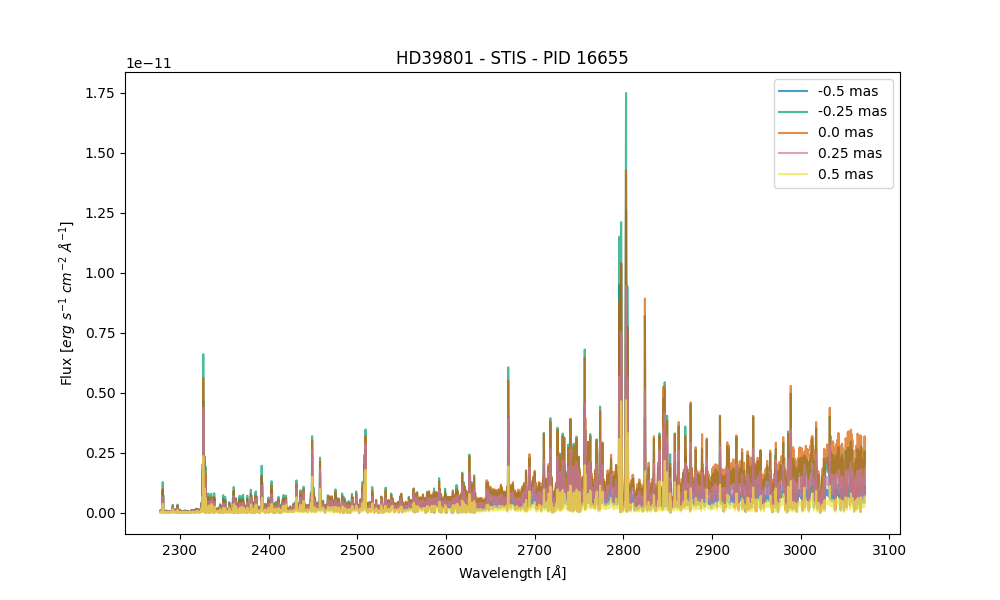

In [29]:
# Clear the older plot
plt.close()
plt.figure(4)

# Set sample factor to 2, which is size of STIS resolution element
samplefactor = 2

# Plot the coadds
for val in postvals:
    coadd_filename = 'hst_16655_stis_hd39801_e230m_oen7_cspec.fits'
    coaddfile = f"{datadir_ex2}/newcoadddata_p{val}/products/{coadd_filename}"
    label = f"{str(float(val) * 10)} mas"

    coadddata = fits.getdata(coaddfile)
    wavelength = coadddata['wavelength'][0]
    flux = coadddata['flux'][0]

    plt.plot(downsample_1d(wavelength, samplefactor),
             downsample_1d(flux, samplefactor),
             label=label,
             alpha=0.7)

    targ = fits.getval(coaddfile, 'TARGNAME', ext=0)
    pid = fits.getval(coaddfile, 'PROPOSID', ext=0)
    ins = fits.getval(coaddfile, 'INSTRUME', ext=0)

    plt.title(f'{targ} - {ins} - PID {pid}')
    plt.xlabel(r'Wavelength [$\AA$]')
    plt.ylabel(r'Flux [$erg\ s^{-1}\ cm^{-2}\ \AA^{-1}$]')
    plt.legend()

# Show the plot below
plt.show()

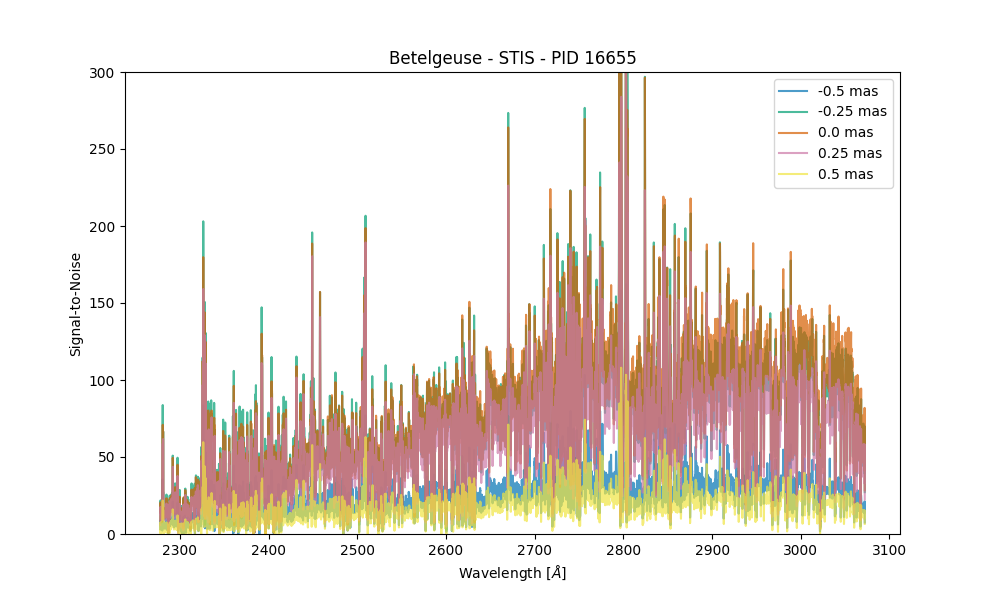

In [30]:
# Also plot the SNR
# Clear the older plot
plt.close()
plt.figure(5)

# Plot the coadds
for val in postvals:
    coadd_filename = 'hst_16655_stis_hd39801_e230m_oen7_cspec.fits'
    coaddfile = f"{datadir_ex2}/newcoadddata_p{val}/products/{coadd_filename}"
    label = f"{str(float(val) * 10)} mas"

    coadddata = fits.getdata(coaddfile)
    wavelength = coadddata['wavelength'][0]
    snr = coadddata['snr'][0]
    plt.plot(downsample_1d(wavelength, samplefactor),
             downsample_1d(snr, samplefactor),
             alpha=0.7,
             label=label)

    targ = fits.getval(coaddfile, 'TARGNAME', ext=0)
    pid = fits.getval(coaddfile, 'PROPOSID', ext=0)
    ins = fits.getval(coaddfile, 'INSTRUME', ext=0)

    plt.title(f'Betelgeuse - {ins} - PID {pid}')
    plt.ylim(0, 300)
    plt.xlabel(r'Wavelength [$\AA$]')
    plt.ylabel(r'Signal-to-Noise')
    plt.legend()

# Show the plot below
plt.show()

We can see from these plots that the flux and SNR decrease the further away from the center of the star you get.

<a id = stisflux></a>
# Example 3: A STIS dataset with flux rejection

<a id = data3></a>
### 3.1 Obtaining Data Products

For the next example, we will at Program ID 16196, a COS and STIS program that observed [MRK-817](https://simbad.cds.unistra.fr/simbad/sim-basic?Ident=mrk+817&submit=SIMBAD+search).

We will again use `astroquery` to download the dataproducts for this program. We will create a folder called `./16655` for the 1D extracted COS and STIS spectra (`x1ds` and `sx1s`) for all visits in this program, as well as the `x1dsums` for the COS data. We will also create a subfolder called `products`, which will store the downloaded coadded data. The log file for this program is named `HASP_16196.out`.

In [31]:
# Creating directories for our data and coadded products
datadir_ex3 = Path("./16196/")
productsdir_ex3 = Path("./16196/products/")

datadir_ex3.mkdir(exist_ok=True)
productsdir_ex3.mkdir(exist_ok=True)

In [32]:
%%capture output

# Querying and downloading calibrated products
query_ex3 = Observations.query_criteria(
    proposal_id=16196, 
    provenance_name=["CALSTIS", "CALCOS"],
    target_name="MRK-817"
)

prodlist_ex3 = Observations.get_product_list(
    query_ex3
)

prodlist_ex3 = Observations.filter_products(
    prodlist_ex3,
    project=["CALSTIS", "CALCOS"],
    productSubGroupDescription=["X1D", "X1DSUM", "SX1"]
)

# Querying and downloading coadded products
query_ex3_coadds = Observations.query_criteria(
    proposal_id=16196, 
    provenance_name="HASP",
    target_name="MRK-817"
)

prodlist_ex3_coadds = Observations.get_product_list(
    query_ex3_coadds
)

prodlist_ex3_coadds = Observations.filter_products(
    prodlist_ex3_coadds, 
    productType="SCIENCE",
    productSubGroupDescription="CSPEC"
)

# Combining the two product lists
combined_ex3 = vstack([prodlist_ex3, prodlist_ex3_coadds])

# Downloading the products
Observations.download_products(
    combined_ex3,
    download_dir=str(datadir_ex3)
)

# Organizing the files 
consolidate_files(datadir_ex3)

In [33]:
with open('output.txt', 'a') as file:
    file.write(output.stdout)

In [34]:
# Use `glob` to make a list of every x1d file available in MAST for this PID
# Then print out a table of some table info on the program
# Note that this program has both x1d and sx1 extracted data products!
allfiles = glob.glob(os.path.join(datadir_ex3, '*_x1d.fits'))\
         + glob.glob(os.path.join(datadir_ex3, '*_sx1.fits'))
print('rootname  target  visit  grating')
for myfile in sorted(allfiles):
    hdr0 = fits.getheader(myfile, ext=0)
    print(hdr0['rootname'], hdr0['targname'],
          hdr0['obset_id'], hdr0['opt_elem'])
print(f'N files from MAST = {len(allfiles)}')

rootname  target  visit  grating
lede01icq MRK-817 01 G130M
lede01ieq MRK-817 01 G130M
lede01igq MRK-817 01 G130M
lede01iiq MRK-817 01 G130M
lede01iqq MRK-817 01 G160M
lede01isq MRK-817 01 G160M
lede01iuq MRK-817 01 G160M
lede01iwq MRK-817 01 G160M
lede02vbq MRK-817 02 G130M
lede02vdq MRK-817 02 G130M
lede02vfq MRK-817 02 G130M
lede02vhq MRK-817 02 G130M
lede02vjq MRK-817 02 G160M
lede02vlq MRK-817 02 G160M
lede02vnq MRK-817 02 G160M
lede02vpq MRK-817 02 G160M
lede03g0q MRK-817 03 G130M
lede03g2q MRK-817 03 G130M
lede03g4q MRK-817 03 G130M
lede03g6q MRK-817 03 G130M
lede03g8q MRK-817 03 G160M
lede03gaq MRK-817 03 G160M
lede03gcq MRK-817 03 G160M
lede03geq MRK-817 03 G160M
lede04maq MRK-817 04 G130M
lede04mcq MRK-817 04 G130M
lede04meq MRK-817 04 G130M
lede04mgq MRK-817 04 G130M
lede04miq MRK-817 04 G160M
lede04mkq MRK-817 04 G160M
lede04mmq MRK-817 04 G160M
lede04moq MRK-817 04 G160M
lede05qcq MRK-817 05 G130M
lede05qeq MRK-817 05 G130M
lede05qgq MRK-817 05 G130M
lede05qiq MRK-817 05 G

lede10j8q MRK-817 10 G160M
lede10jaq MRK-817 10 G160M
lede10jcq MRK-817 10 G160M
lede11a4q MRK-817 11 G130M
lede11a6q MRK-817 11 G130M
lede11a8q MRK-817 11 G130M
lede11aaq MRK-817 11 G130M
lede11adq MRK-817 11 G160M
lede11afq MRK-817 11 G160M
lede11ahq MRK-817 11 G160M
lede11ajq MRK-817 11 G160M
lede12lzq MRK-817 12 G130M
lede12m1q MRK-817 12 G130M
lede12m3q MRK-817 12 G130M
lede12m5q MRK-817 12 G130M
lede12m7q MRK-817 12 G160M
lede12m9q MRK-817 12 G160M
lede12mbq MRK-817 12 G160M
lede12mdq MRK-817 12 G160M
lede14jzq MRK-817 14 G130M
lede14k1q MRK-817 14 G130M
lede14k3q MRK-817 14 G130M
lede14k5q MRK-817 14 G130M
lede14k7q MRK-817 14 G160M
lede14k9q MRK-817 14 G160M
lede14kbq MRK-817 14 G160M
lede14kdq MRK-817 14 G160M
lede15ngq MRK-817 15 G130M
lede15niq MRK-817 15 G130M
lede15nkq MRK-817 15 G130M
lede15nmq MRK-817 15 G130M
lede15noq MRK-817 15 G160M
lede15nqq MRK-817 15 G160M
lede15nsq MRK-817 15 G160M
lede15nuq MRK-817 15 G160M
lede16vzq MRK-817 16 G130M
lede16w2q MRK-817 16 G130M
l

lede1wsxq MRK-817 1W G130M
lede1wszq MRK-817 1W G130M
lede1wt1q MRK-817 1W G130M
lede1wt3q MRK-817 1W G160M
lede1wt5q MRK-817 1W G160M
lede1wt7q MRK-817 1W G160M
lede1wt9q MRK-817 1W G160M
lede1xz3q MRK-817 1X G130M
lede1xz5q MRK-817 1X G130M
lede1xz7q MRK-817 1X G130M
lede1xzcq MRK-817 1X G130M
lede1xzeq MRK-817 1X G160M
lede1xzgq MRK-817 1X G160M
lede1xziq MRK-817 1X G160M
lede1xzkq MRK-817 1X G160M
lede1ykxq MRK-817 1Y G130M
lede1ykzq MRK-817 1Y G130M
lede1yl1q MRK-817 1Y G130M
lede1yl3q MRK-817 1Y G130M
lede1yl5q MRK-817 1Y G160M
lede1yl7q MRK-817 1Y G160M
lede1yl9q MRK-817 1Y G160M
lede1ylbq MRK-817 1Y G160M
lede1zlsq MRK-817 1Z G130M
lede1zluq MRK-817 1Z G130M
lede1zlwq MRK-817 1Z G130M
lede1zlyq MRK-817 1Z G130M
lede1zm0q MRK-817 1Z G160M
lede1zm2q MRK-817 1Z G160M
lede1zm4q MRK-817 1Z G160M
lede1zm6q MRK-817 1Z G160M
lede20alq MRK-817 20 G130M
lede20anq MRK-817 20 G130M
lede20apq MRK-817 20 G130M
lede20arq MRK-817 20 G130M
lede20atq MRK-817 20 G160M
lede20avq MRK-817 20 G160M
l

lede2ogzq MRK-817 2O G130M
lede2oh1q MRK-817 2O G130M
lede2oh7q MRK-817 2O G130M
lede2oh9q MRK-817 2O G160M
lede2ohbq MRK-817 2O G160M
lede2ohdq MRK-817 2O G160M
lede2ohhq MRK-817 2O G160M
lede2pu8q MRK-817 2P G130M
lede2puaq MRK-817 2P G130M
lede2pucq MRK-817 2P G130M
lede2pueq MRK-817 2P G130M
lede2pugq MRK-817 2P G160M
lede2puiq MRK-817 2P G160M
lede2pukq MRK-817 2P G160M
lede2pumq MRK-817 2P G160M
lede2qcuq MRK-817 2Q G130M
lede2qcwq MRK-817 2Q G130M
lede2qcyq MRK-817 2Q G130M
lede2qd0q MRK-817 2Q G130M
lede2qd2q MRK-817 2Q G160M
lede2qd4q MRK-817 2Q G160M
lede2qd6q MRK-817 2Q G160M
lede2qd8q MRK-817 2Q G160M
lede2rl6q MRK-817 2R G130M
lede2rl8q MRK-817 2R G130M
lede2rlaq MRK-817 2R G130M
lede2rlcq MRK-817 2R G130M
lede2rleq MRK-817 2R G160M
lede2rlgq MRK-817 2R G160M
lede2rliq MRK-817 2R G160M
lede2rlkq MRK-817 2R G160M
lede2sk1q MRK-817 2S G130M
lede2sk4q MRK-817 2S G130M
lede2sk6q MRK-817 2S G130M
lede2sk8q MRK-817 2S G130M
lede2skaq MRK-817 2S G160M
lede2skcq MRK-817 2S G160M
l

lede3lprq MRK-817 3L G130M
lede3lptq MRK-817 3L G130M
lede3lpvq MRK-817 3L G130M
lede3lpxq MRK-817 3L G160M
lede3lpzq MRK-817 3L G160M
lede3lq1q MRK-817 3L G160M
lede3lq3q MRK-817 3L G160M
lede3me4q MRK-817 3M G130M
lede3me6q MRK-817 3M G130M
lede3me8q MRK-817 3M G130M
lede3meaq MRK-817 3M G130M
lede3medq MRK-817 3M G160M
lede3mefq MRK-817 3M G160M
lede3mehq MRK-817 3M G160M
lede3mejq MRK-817 3M G160M
lede3nc4q MRK-817 3N G130M
lede3nc6q MRK-817 3N G130M
lede3nc8q MRK-817 3N G130M
lede3ncaq MRK-817 3N G130M
lede3ncdq MRK-817 3N G160M
lede3ncgq MRK-817 3N G160M
lede3ncjq MRK-817 3N G160M
lede3nclq MRK-817 3N G160M
lede3ncqq MRK-817 3N G130M
lede3nctq MRK-817 3N G130M
lede3ncwq MRK-817 3N G130M
lede3nd5q MRK-817 3N G130M
lede3pr0q MRK-817 3P G130M
lede3pr2q MRK-817 3P G130M
lede3pr4q MRK-817 3P G130M
lede3pr6q MRK-817 3P G130M
lede3pr9q MRK-817 3P G160M
lede3prbq MRK-817 3P G160M
lede3prdq MRK-817 3P G160M
lede3prfq MRK-817 3P G160M
lede3qa2q MRK-817 3Q G160M
lede3qa4q MRK-817 3Q G160M
l

lede51hbq MRK-817 51 G160M
lede51hdq MRK-817 51 G160M
lede51hfq MRK-817 51 G160M
lede52mkq MRK-817 52 G130M
lede52mmq MRK-817 52 G130M
lede52moq MRK-817 52 G130M
lede52mqq MRK-817 52 G130M
lede53mvq MRK-817 53 G160M
lede53mxq MRK-817 53 G160M
lede56a3q MRK-817 56 G130M
lede56a5q MRK-817 56 G130M
lede56a7q MRK-817 56 G130M
lede56ahq MRK-817 56 G130M
lede57azq MRK-817 57 G160M
lede57b2q MRK-817 57 G160M
lede59npq MRK-817 59 G130M
lede59nrq MRK-817 59 G130M
lede59ntq MRK-817 59 G130M
lede59nvq MRK-817 59 G130M
lede59nxq MRK-817 59 G160M
lede59nzq MRK-817 59 G160M
lede59o1q MRK-817 59 G160M
lede59o3q MRK-817 59 G160M
lede60waq MRK-817 60 G130M
lede60weq MRK-817 60 G130M
lede60wgq MRK-817 60 G130M
lede60wiq MRK-817 60 G130M
lede60wkq MRK-817 60 G160M
lede60x5q MRK-817 60 G160M
lede60x7q MRK-817 60 G160M
lede60xbq MRK-817 60 G160M
lede61dtq MRK-817 61 G130M
lede61dvq MRK-817 61 G130M
lede61dxq MRK-817 61 G130M
lede61dzq MRK-817 61 G130M
lede61e1q MRK-817 61 G160M
lede61e3q MRK-817 61 G160M
l

lede89bmq MRK-817 89 G160M
lede89boq MRK-817 89 G160M
lede89bqq MRK-817 89 G160M
lede90dnq MRK-817 90 G130M
lede90dpq MRK-817 90 G130M
lede90drq MRK-817 90 G130M
lede90dtq MRK-817 90 G130M
lede90dvq MRK-817 90 G160M
lede90dxq MRK-817 90 G160M
lede90dzq MRK-817 90 G160M
lede90e1q MRK-817 90 G160M
lede91p8q MRK-817 91 G130M
lede91paq MRK-817 91 G130M
lede91pcq MRK-817 91 G130M
lede91peq MRK-817 91 G130M
lede91pgq MRK-817 91 G160M
lede91piq MRK-817 91 G160M
lede91pkq MRK-817 91 G160M
lede91pmq MRK-817 91 G160M
lede92k3q MRK-817 92 G130M
lede92k5q MRK-817 92 G130M
lede92k7q MRK-817 92 G130M
lede92k9q MRK-817 92 G130M
lede92kbq MRK-817 92 G160M
lede92kdq MRK-817 92 G160M
lede92kfq MRK-817 92 G160M
lede92khq MRK-817 92 G160M
lede93stq MRK-817 93 G130M
lede93svq MRK-817 93 G130M
lede93sxq MRK-817 93 G130M
lede93szq MRK-817 93 G130M
lede93t1q MRK-817 93 G160M
lede93t3q MRK-817 93 G160M
lede93t5q MRK-817 93 G160M
lede93t7q MRK-817 93 G160M
lede94r5q MRK-817 94 G130M
lede94r7q MRK-817 94 G130M
l

<a id = logs3></a>
### 3.2 Examining Output Logs

In [35]:
# Set up path to the coadd log file
logfile = './logfiles/HASP_16196.out'

with open(logfile, 'r') as f:
    for line in f:
        print(line.strip())

2024256094248 INFO src=hasp_retrieve_inputs.filter_out_low_quality_datasets msg="Removed COS ASN LEDE1H030 containing dict_keys(['lede1hhoq', 'lede1hhqq'])"
2024256094248 INFO src=hasp_retrieve_inputs.filter_out_low_quality_datasets msg="Removed COS ASN LEDE1X010 containing dict_keys(['lede1xz3q', 'lede1xz5q', 'lede1xz7q', 'lede1xzcq'])"
2024256094248 INFO src=hasp_retrieve_inputs.filter_out_low_quality_datasets msg="Removed COS ASN LEDE99020 containing dict_keys(['lede99wfq', 'lede99whq'])"
2024256094248 INFO src=hasp_retrieve_inputs.filter_out_low_quality_datasets msg="Removed COS ASN LEDE0Z010 containing dict_keys(['lede0zz2q', 'lede0zz4q', 'lede0zz6q', 'lede0zz8q'])"
2024256094248 INFO src=hasp_retrieve_inputs.filter_out_low_quality_datasets msg="Removed COS ASN LEDE1Z010 containing dict_keys(['lede1zlsq', 'lede1zluq', 'lede1zlwq', 'lede1zlyq'])"
2024256094248 INFO src=hasp_retrieve_inputs.filter_out_low_quality_datasets msg="Removed COS ASN LEDE1X030 containing dict_keys(['lede1xz

In [36]:
# Use find_rejects function from first example to make a list of rejected files
listofprerejects, listoffluxrejects = find_rejects(logfile, '16196', allfiles)
print('Files removed before co-addition:')
[print(f"{file}") for file in sorted(listofprerejects)]
print(f'Files removed by flux checker: {sorted(listoffluxrejects)}')
print(f'Number of files removed before co-addition = {len(listofprerejects)}')
print(f'Number of files removed by flux checker = {len(listoffluxrejects)}')

Files removed before co-addition:
lede0zziq_x1d.fits
lede0zzkq_x1d.fits
lede0zzmq_x1d.fits
lede0zzoq_x1d.fits
lede1ajaq_x1d.fits
lede1ajcq_x1d.fits
lede1ajeq_x1d.fits
lede1ajgq_x1d.fits
lede1ajiq_x1d.fits
lede1ajkq_x1d.fits
lede1ajmq_x1d.fits
lede1ajoq_x1d.fits
lede1dkfq_x1d.fits
lede1dkhq_x1d.fits
lede1dkjq_x1d.fits
lede1dklq_x1d.fits
lede1dknq_x1d.fits
lede1dkpq_x1d.fits
lede1dkrq_x1d.fits
lede1dktq_x1d.fits
lede1ftfq_x1d.fits
lede1fthq_x1d.fits
lede1ftjq_x1d.fits
lede1ftlq_x1d.fits
lede1ftoq_x1d.fits
lede1ftqq_x1d.fits
lede1fumq_x1d.fits
lede1fuoq_x1d.fits
lede1hhqq_x1d.fits
lede1jayq_x1d.fits
lede1jb0q_x1d.fits
lede1jb2q_x1d.fits
lede1jb4q_x1d.fits
lede1jb6q_x1d.fits
lede1jb8q_x1d.fits
lede1jbaq_x1d.fits
lede1jbcq_x1d.fits
lede1kmqq_x1d.fits
lede1kmsq_x1d.fits
lede1kmuq_x1d.fits
lede1kmwq_x1d.fits
lede1kmyq_x1d.fits
lede1kn0q_x1d.fits
lede1kn2q_x1d.fits
lede1kn4q_x1d.fits
lede1ljoq_x1d.fits
lede1ljqq_x1d.fits
lede1ljsq_x1d.fits
lede1ljuq_x1d.fits
lede1ljwq_x1d.fits
lede1ljzq_x1d.fi

As you can see, many files were removed before the co-add began, and many more were removed by the flux checker! If you're curious, we can also look through the headers for the rejected files too.

In [37]:
# Check out the headers of the files for quality
readheaders(listofprerejects, datadir_ex3)

16196/lede0zziq_x1d.fits
Exposure time = 0.0
Planned exposure time = 522.0
Shutter = Closed
Aperture used = PSA
Grating used = G130M
Exposure flag = NO DATA
Fine guiding lock = FINE
POSTARG1 / POSTARG2 = 0.0 / 0.0
Quality comments from 16196/lede0z040_x1dsum.fits
    COM1 = Guide star acquisition delayed.
    COM2 = COS internal shutter closed. No counts in exposure.
    COM3 = Actual exposure time significantly less than planned exposure.
Moving target? No
Date file was written = 2025-07-18
Version of calibration software = HSTDP 2025_1


16196/lede0zzkq_x1d.fits
Exposure time = 0.0
Planned exposure time = 522.0
Shutter = Closed
Aperture used = PSA
Grating used = G130M
Exposure flag = NO DATA
Fine guiding lock = FINE
POSTARG1 / POSTARG2 = 0.0 / 0.0
Quality comments from 16196/lede0z040_x1dsum.fits
    COM1 = Guide star acquisition delayed.
    COM2 = COS internal shutter closed. No counts in exposure.
    COM3 = Actual exposure time significantly less than planned exposure.
Moving tar

Exposure time = 45.088
Planned exposure time = 195.0
Shutter = Open
Aperture used = PSA
Grating used = G160M
Exposure flag = INTERRUPTED
Fine guiding lock = FINE
POSTARG1 / POSTARG2 = 0.0 / 0.0
Quality comments from 16196/lede1h030_x1dsum.fits
    COM1 = Take Data Flag NOT on throughout observation.
    COM2 = COS light path blocked during exposure.
    COM3 = Actual exposure time may be significantly less than planned.
Moving target? No
Date file was written = 2025-07-18
Version of calibration software = HSTDP 2025_1


16196/lede1jayq_x1d.fits
Exposure time = 0.0
Planned exposure time = 60.0
Shutter = Closed
Aperture used = PSA
Grating used = G130M
Exposure flag = NO DATA
Fine guiding lock = FINE
POSTARG1 / POSTARG2 = 0.0 / 0.0
Quality comments from 16196/lede1j010_x1dsum.fits
    COM1 = Guide star acquisition failed. Actual guide mode is gyro.
    COM2 = COS internal shutter closed. No counts in exposure.
    COM3 = Actual exposure time significantly less than planned exposure.
Movin

Exposure time = 0.0
Planned exposure time = 175.0
Shutter = Closed
Aperture used = PSA
Grating used = G160M
Exposure flag = NO DATA
Fine guiding lock = FINE
POSTARG1 / POSTARG2 = 0.0 / 0.0
Quality comments from 16196/lede1j020_x1dsum.fits
    COM1 = Guide star acquisition failed. Actual guide mode is gyro.
    COM2 = COS internal shutter closed. No counts in exposure.
    COM3 = Actual exposure time significantly less than planned exposure.
Moving target? No
Date file was written = 2025-07-18
Version of calibration software = HSTDP 2025_1


16196/lede1jb8q_x1d.fits


Exposure time = 0.0
Planned exposure time = 180.0
Shutter = Closed
Aperture used = PSA
Grating used = G160M
Exposure flag = NO DATA
Fine guiding lock = FINE
POSTARG1 / POSTARG2 = 0.0 / 0.0
Quality comments from 16196/lede1j020_x1dsum.fits
    COM1 = Guide star acquisition failed. Actual guide mode is gyro.
    COM2 = COS internal shutter closed. No counts in exposure.
    COM3 = Actual exposure time significantly less than planned exposure.
Moving target? No
Date file was written = 2025-07-18
Version of calibration software = HSTDP 2025_1


16196/lede1jbaq_x1d.fits
Exposure time = 0.0
Planned exposure time = 195.0
Shutter = Closed
Aperture used = PSA
Grating used = G160M
Exposure flag = NO DATA
Fine guiding lock = FINE
POSTARG1 / POSTARG2 = 0.0 / 0.0
Quality comments from 16196/lede1j030_x1dsum.fits
    COM1 = Guide star acquisition failed. Actual guide mode is gyro.
    COM2 = COS internal shutter closed. No counts in exposure.
    COM3 = Actual exposure time significantly less than p

Exposure time = 0.0
Planned exposure time = 195.0
Shutter = Closed
Aperture used = PSA
Grating used = G160M
Exposure flag = NO DATA
Fine guiding lock = FINE
POSTARG1 / POSTARG2 = 0.0 / 0.0
Quality comments from 16196/lede1x030_x1dsum.fits
    COM1 = Guide star acquisition failed. Actual guide mode is gyro.
    COM2 = COS internal shutter closed. No counts in exposure.
    COM3 = Actual exposure time significantly less than planned exposure.
Moving target? No
Date file was written = 2025-07-18
Version of calibration software = HSTDP 2025_1


16196/lede1xzkq_x1d.fits
Exposure time = 0.0
Planned exposure time = 195.0
Shutter = Closed
Aperture used = PSA
Grating used = G160M
Exposure flag = NO DATA
Fine guiding lock = FINE
POSTARG1 / POSTARG2 = 0.0 / 0.0
Quality comments from 16196/lede1x030_x1dsum.fits
    COM1 = Guide star acquisition failed. Actual guide mode is gyro.
    COM2 = COS internal shutter closed. No counts in exposure.
    COM3 = Actual exposure time significantly less than p

Exposure time = 0.0
Planned exposure time = 60.0
Shutter = Closed
Aperture used = PSA
Grating used = G130M
Exposure flag = NO DATA
Fine guiding lock = FINE
POSTARG1 / POSTARG2 = 0.0 / 0.0
Quality comments from 16196/lede1y010_x1dsum.fits
    COM1 = Guide star acquisition failed. Actual guide mode is gyro.
    COM2 = COS internal shutter closed. No counts in exposure.
    COM3 = Actual exposure time significantly less than planned exposure.
Moving target? No
Date file was written = 2025-07-18
Version of calibration software = HSTDP 2025_1


16196/lede1yl5q_x1d.fits


Exposure time = 0.0
Planned exposure time = 175.0
Shutter = Closed
Aperture used = PSA
Grating used = G160M
Exposure flag = NO DATA
Fine guiding lock = FINE
POSTARG1 / POSTARG2 = 0.0 / 0.0
Quality comments from 16196/lede1y020_x1dsum.fits
    COM1 = Guide star acquisition failed. Actual guide mode is gyro.
    COM2 = COS internal shutter closed. No counts in exposure.
    COM3 = Actual exposure time significantly less than planned exposure.
Moving target? No
Date file was written = 2025-07-18
Version of calibration software = HSTDP 2025_1


16196/lede1yl7q_x1d.fits
Exposure time = 0.0
Planned exposure time = 180.0
Shutter = Closed
Aperture used = PSA
Grating used = G160M
Exposure flag = NO DATA
Fine guiding lock = FINE
POSTARG1 / POSTARG2 = 0.0 / 0.0
Quality comments from 16196/lede1y020_x1dsum.fits
    COM1 = Guide star acquisition failed. Actual guide mode is gyro.
    COM2 = COS internal shutter closed. No counts in exposure.
    COM3 = Actual exposure time significantly less than p

Exposure time = 60.00000000000001
Planned exposure time = 60.0
Shutter = Open
Aperture used = PSA
Grating used = G130M
Exposure flag = NORMAL
Fine guiding lock = FINE/GYRO
POSTARG1 / POSTARG2 = 0.0 / 0.0
Quality comments from 16196/lede2q010_x1dsum.fits
    COM1 = 
    COM2 = 
    COM3 = 
Moving target? No
Date file was written = 2025-07-18
Version of calibration software = HSTDP 2025_1


16196/lede2qcyq_x1d.fits
Exposure time = 60.0
Planned exposure time = 60.0
Shutter = Open
Aperture used = PSA
Grating used = G130M
Exposure flag = NORMAL
Fine guiding lock = FINE/GYRO
POSTARG1 / POSTARG2 = 0.0 / 0.0
Quality comments from 16196/lede2q010_x1dsum.fits
    COM1 = 
    COM2 = 
    COM3 = 
Moving target? No
Date file was written = 2025-07-18
Version of calibration software = HSTDP 2025_1


16196/lede2qd0q_x1d.fits
Exposure time = 60.032000000000004
Planned exposure time = 60.0
Shutter = Open
Aperture used = PSA
Grating used = G130M
Exposure flag = NORMAL
Fine guiding lock = FINE/GYRO
POSTAR

Exposure time = 195.008
Planned exposure time = 195.0
Shutter = Open
Aperture used = PSA
Grating used = G160M
Exposure flag = NORMAL
Fine guiding lock = FINE/GYRO
POSTARG1 / POSTARG2 = 0.0 / 0.0
Quality comments from 16196/lede2q030_x1dsum.fits
    COM1 = 
    COM2 = 
    COM3 = 
Moving target? No
Date file was written = 2025-07-18
Version of calibration software = HSTDP 2025_1


16196/lede2qd8q_x1d.fits


Exposure time = 195.04
Planned exposure time = 195.0
Shutter = Open
Aperture used = PSA
Grating used = G160M
Exposure flag = NORMAL
Fine guiding lock = FINE/GYRO
POSTARG1 / POSTARG2 = 0.0 / 0.0
Quality comments from 16196/lede2q030_x1dsum.fits
    COM1 = 
    COM2 = 
    COM3 = 
Moving target? No
Date file was written = 2025-07-18
Version of calibration software = HSTDP 2025_1


16196/lede2rl6q_x1d.fits
Exposure time = 60.0
Planned exposure time = 60.0
Shutter = Open
Aperture used = PSA
Grating used = G130M
Exposure flag = NORMAL
Fine guiding lock = FINE/GYRO
POSTARG1 / POSTARG2 = 0.0 / 0.0
Quality comments from 16196/lede2r010_x1dsum.fits
    COM1 = 
    COM2 = 
    COM3 = 
Moving target? No
Date file was written = 2025-07-18
Version of calibration software = HSTDP 2025_1


16196/lede2rl8q_x1d.fits
Exposure time = 60.032000000000004
Planned exposure time = 60.0
Shutter = Open
Aperture used = PSA
Grating used = G130M
Exposure flag = NORMAL
Fine guiding lock = FINE/GYRO
POSTARG1 / POSTA

    COM2 = 
    COM3 = 
Moving target? No
Date file was written = 2025-07-18
Version of calibration software = HSTDP 2025_1


16196/lede4cepq_x1d.fits
Exposure time = 175.04
Planned exposure time = 175.0
Shutter = Open
Aperture used = PSA
Grating used = G160M
Exposure flag = NORMAL
Fine guiding lock = FINE/GYRO
POSTARG1 / POSTARG2 = 0.0 / 0.0
Quality comments from 16196/lede4c020_x1dsum.fits
    COM1 = 
    COM2 = 
    COM3 = 
Moving target? No
Date file was written = 2025-07-18
Version of calibration software = HSTDP 2025_1


16196/lede4cerq_x1d.fits
Exposure time = 180.0
Planned exposure time = 180.0
Shutter = Open
Aperture used = PSA
Grating used = G160M
Exposure flag = NORMAL
Fine guiding lock = FINE/GYRO
POSTARG1 / POSTARG2 = 0.0 / 0.0
Quality comments from 16196/lede4c020_x1dsum.fits
    COM1 = 
    COM2 = 
    COM3 = 
Moving target? No
Date file was written = 2025-07-18
Version of calibration software = HSTDP 2025_1


16196/lede4cetq_x1d.fits
Exposure time = 195.00799999999998
P

    COM3 = 
Moving target? No
Date file was written = 2025-07-18
Version of calibration software = HSTDP 2025_1


16196/lede4dp7q_x1d.fits
Exposure time = 60.0
Planned exposure time = 60.0
Shutter = Open
Aperture used = PSA
Grating used = G130M
Exposure flag = NORMAL
Fine guiding lock = FINE/GYRO
POSTARG1 / POSTARG2 = 0.0 / 0.0
Quality comments from 16196/lede4d010_x1dsum.fits
    COM1 = 


    COM2 = 
    COM3 = 
Moving target? No
Date file was written = 2025-07-18
Version of calibration software = HSTDP 2025_1


16196/lede4dp9q_x1d.fits
Exposure time = 60.032000000000004
Planned exposure time = 60.0
Shutter = Open
Aperture used = PSA
Grating used = G130M
Exposure flag = NORMAL
Fine guiding lock = FINE/GYRO
POSTARG1 / POSTARG2 = 0.0 / 0.0
Quality comments from 16196/lede4d010_x1dsum.fits
    COM1 = 
    COM2 = 
    COM3 = 
Moving target? No
Date file was written = 2025-07-18
Version of calibration software = HSTDP 2025_1


16196/lede4dpbq_x1d.fits
Exposure time = 60.032000000000004
Planned exposure time = 60.0
Shutter = Open
Aperture used = PSA
Grating used = G130M
Exposure flag = NORMAL
Fine guiding lock = FINE/GYRO
POSTARG1 / POSTARG2 = 0.0 / 0.0
Quality comments from 16196/lede4d010_x1dsum.fits
    COM1 = 
    COM2 = 
    COM3 = 
Moving target? No
Date file was written = 2025-07-18
Version of calibration software = HSTDP 2025_1


16196/lede4dpdq_x1d.fits
Exposure time

Taking a glance at the output in the cell above, we can see that many files have data quality issues. We can create a co-add with the data quality filtering left on, but the flux checker turned off. These types of data products can be useful in cases where the science doesn't depend on the accuracy of the data's absolute flux.

<a id = coadd3></a>
### 3.3 Running `coadd`

Since we want to co-add everything again, just without the flux filtering, we don't need to make a new data sub-directory. We should change the output directory name so that the original co-adds are not overwritten. We run `coadd` similarly to [Section 1.4](#coadd1), but this time with just the `-t -999` flag.

In [38]:
# Set up the path to your data directory
finaldatadir = os.path.join(datadir_ex3, 'products_nofluxfilter')

# Make on output directory
os.makedirs(finaldatadir, exist_ok=True)

And now we run `coadd`:

In [39]:
%%capture output

!swrapper -i ./16196/ -o ./16196/products_nofluxfilter -t -999

In [40]:
with open('output.txt', 'a') as file:
    file.write(output.stdout)

Because of the number of datasets, this co-add takes much longer to compute. Once it's done, we can plot the results.

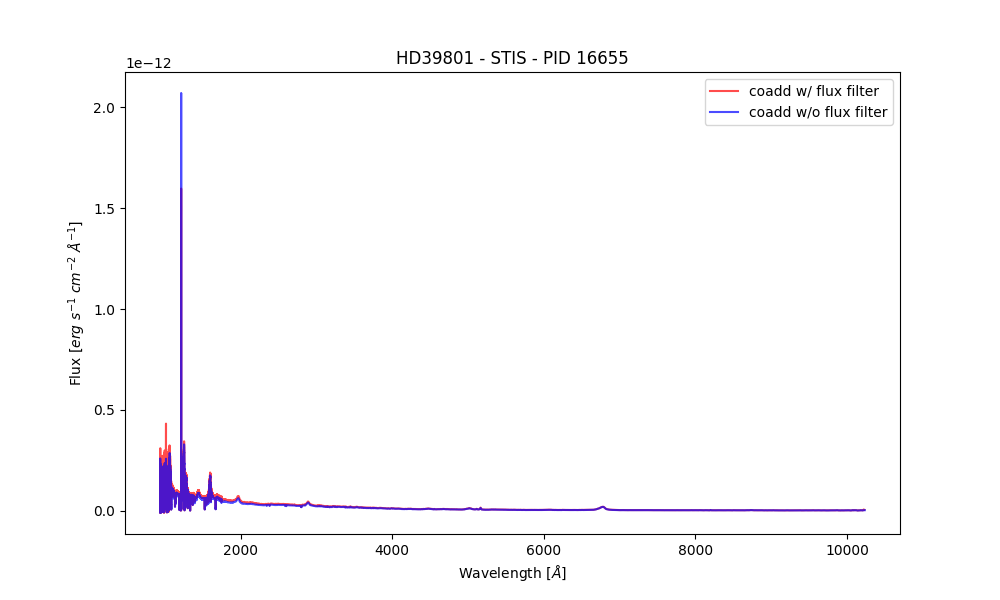

In [41]:
# Clear the older plot
plt.close()
plt.figure(6)

fn = 'hst_16196_cos-stis_mrk-817_g130m-g160m-sg230l-g430l-g750l_lede_cspec.fits'

# Plot the old coadd
oldcoaddfile = os.path.join(datadir_ex3, 'products', fn)
oldcoadddata = fits.getdata(oldcoaddfile)
oldwavelength = oldcoadddata['wavelength'][0]
oldflux = oldcoadddata['flux'][0]

plt.plot(downsample_1d(oldwavelength, samplefactor),
         downsample_1d(oldflux, samplefactor),
         label='coadd w/ flux filter',
         color="red",
         alpha=0.7)

# Plot the new coadd
newcoaddfile = os.path.join(datadir_ex3, 'products_nofluxfilter', fn)
newcoadddata = fits.getdata(newcoaddfile)
newwavelength = newcoadddata['wavelength'][0]
newflux = newcoadddata['flux'][0]

plt.plot(downsample_1d(newwavelength, samplefactor),
         downsample_1d(newflux, samplefactor),
         label='coadd w/o flux filter',
         color="blue",
         alpha=0.7)

targ = fits.getval(coaddfile, 'TARGNAME', ext=0)
pid = fits.getval(coaddfile, 'PROPOSID', ext=0)
ins = fits.getval(coaddfile, 'INSTRUME', ext=0)

plt.title(f'{targ} - {ins} - PID {pid}')
plt.xlabel(r'Wavelength [$\AA$]')
plt.ylabel(r'Flux [$erg\ s^{-1}\ cm^{-2}\ \AA^{-1}$]')
plt.legend()

# Show the plot below
plt.show()

The plot above shows that the flux is lower in the dataset made without the flux checker on. This means that the previously-rejected datasets were of lower flux. However, zooming in on some of the absorption features, we can see that the wings of some lines are broader in the dataset with no flux rejection, which can be useful in some science cases where these features are faint.

# Happy co-adding!

### There are more tutorial notebooks for custom co-addition cases in [this repo](https://github.com/spacetelescope/hst_notebooks/tree/main/notebooks/HASP/Setup), check them out!

## About this Notebook
**Authors:** Elaine Frazer (efrazer@stsci.edu), Sierra Gomez (sigomez@stsci.edu), Debopam Som (dsom@stsci.edu), Anna Payne (apayne@stsci.edu)

**Updated on:** 10/20/2024

*This tutorial was generated to be in compliance with the [STScI style guides](https://github.com/spacetelescope/style-guides) and would like to cite the [Jupyter guide](https://github.com/spacetelescope/style-guides/blob/master/templates/example_notebook.ipynb) in particular.*

## Citations

If you use `astropy`, `astroquery`, `numpy`, or `matplotlib`, for published research, please cite the authors. Follow these links for more information about citations:

* [Citing `astropy`](https://docs.astropy.org/en/stable/index.html)

* [Citing `astroquery`](https://astroquery.readthedocs.io/en/latest/)

* [Citing `matplotlib`](https://matplotlib.org/stable/users/project/citing.html)

* [Citing `numpy`](https://numpy.org/citing-numpy/)

<hr>


[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 